<a href="https://colab.research.google.com/github/Chinmaya-3141/Capstone-Project/blob/main/Improving_Capstone_Classification_EfficientNetB4_IntermediateFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EfficientNet-B4**

## Install and import necessary libraries

In [ ]:
!python --version
!pip show torch

Python 3.9.16
Name: torch
Version: 1.13.1+cu116
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.9/dist-packages
Requires: typing-extensions
Required-by: efficientnet-pytorch, fastai, torchaudio, torchtext, torchvision


In [ ]:
!pip install torchinfo -qq
!pip install efficientnet_pytorch -qq

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Python 3.9.16\
Name: torch\
Version: 1.13.1+cu116\
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration\
Home-page: https://pytorch.org/\
Author: PyTorch Team\
Author-email: packages@pytorch.org\
License: BSD-3\
Location: /usr/local/lib/python3.9/dist-packages\
Requires: typing-extensions\
Required-by: fastai, torchaudio, torchtext, torchvision\


In [ ]:
import os
import time
from numba import cuda
import PIL
from time import time

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchsummary import summary as tssum
from torchinfo import summary as tisum

In [ ]:
# from torchvision.models import efficientnet_b7 as en7
from efficientnet_pytorch import EfficientNet as en4

## Data Preparation

### Setup

In [ ]:
# Define the root directory of your dataset
path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/Resized Data/Resized Data_320x320'

In [ ]:
# Check if GPU is available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
torch.manual_seed(42)

In [ ]:
batchsize = 20
dimension=380
channels = 3

In [ ]:
# Transform to apply to complete dataset

transform = transforms.Compose([
    transforms.Resize(380),
    transforms.CenterCrop(380),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5121, 0.5121, 0.5121], std=[0.2298, 0.2298, 0.2298])
])

# Define transform to augment Pneumonia data and then combine it with the rest of the data

augmented_transforms = transforms.Compose([
    transforms.Resize(380),
    transforms.RandomRotation(degrees=20),
    transforms.CenterCrop(380),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5121, 0.5121, 0.5121], std=[0.2298, 0.2298, 0.2298])
])

### Implementation 1

In [ ]:
drop_classes = ['Covid', 'Normal']
list1 = [(path,transform,[]),(path,augmented_transforms,drop_classes)]

In [ ]:
class ConcatImageFolder(ConcatDataset):
    def __init__(self, folder_transforms):
        # create a list of ImageFolder datasets from the input folder/transform pairs
        datasets = []
        for folder, transform, drop_classes in folder_transforms:
            data = ImageFolder(folder, transform=transforms.Compose([transform]))
            data.samples = [(x, y) for x, y in data.samples if data.classes[y] not in drop_classes]
            data.classes = [c for c in data.classes if c not in drop_classes]
            datasets.append(data)
            

        # call the parent ConcatDataset constructor with the list of datasets
        super().__init__(datasets)

        # store the union of all classes from the constituent datasets
        self.classes = list(set().union(*[dataset.classes for dataset in datasets]))

In [ ]:
datavar = ConcatImageFolder(list1)

In [ ]:
datavar.classes

['Pneumonia', 'Normal', 'Covid']

In [ ]:
print(f"Number of images: {len(datavar)}")

Number of images: 9307


### Implementation 2

In [ ]:
# Load the dataset using the ImageFolder function and apply the transformations

train_dataset = ImageFolder(root=path, transform=transform)

In [ ]:
# Create new dataset without the specified classes

augmented_dataset = ImageFolder(root=path, transform=augmented_transforms)
augmented_dataset.samples = [(x, y) for x, y in augmented_dataset.samples if augmented_dataset.classes[y] not in drop_classes]
augmented_dataset.classes = [c for c in augmented_dataset.classes if c not in drop_classes]

In [ ]:
# Combine the original and augmented datasets into a single dataset
# combined_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_dataset])

datavar2 = ConcatDataset([train_dataset, augmented_dataset])

In [ ]:
print(type(train_dataset),"\n",type(augmented_dataset),"\n",type(datavar2))

<class 'torchvision.datasets.folder.ImageFolder'> 
 <class 'torchvision.datasets.folder.ImageFolder'> 
 <class 'torch.utils.data.dataset.ConcatDataset'>


In [ ]:
len(datavar2)

9307

In [ ]:
print(f"Number of images: {len(datavar2)}")

Number of images: 9307


### Train-Test-Split

In [ ]:
train_data, test_data = torch.utils.data.random_split(datavar, [int(0.8*len(datavar)), len(datavar)-int(0.8*len(datavar))])

In [ ]:
# Define the data loaders

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [ ]:
# Calculate the mean and standard deviation of the training data

# mean = 0.0
# std = 0.0
# num_samples = 0

# for images, _ in train_loader:
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1).to(device)
#     mean += images.mean(2).sum(0).to(device)
#     std += images.std(2).sum(0).to(device)
#     num_samples += batch_samples

# mean /= num_samples
# std /= num_samples

# print("Mean:", mean)
# print("Standard deviation:", std)

## Modelling

In [ ]:
# EfficientNetB7 requires 380*380 images

model = en4.from_pretrained('efficientnet-b4', num_classes=3)

Loaded pretrained weights for efficientnet-b4


In [ ]:
# Load the model to device

model.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
# Display the summary of the model

print(tssum(model, input_size=(channels,dimension,dimension)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 381, 381]               0
Conv2dStaticSamePadding-2         [-1, 48, 190, 190]           1,296
       BatchNorm2d-3         [-1, 48, 190, 190]              96
MemoryEfficientSwish-4         [-1, 48, 190, 190]               0
         ZeroPad2d-5         [-1, 48, 192, 192]               0
Conv2dStaticSamePadding-6         [-1, 48, 190, 190]             432
       BatchNorm2d-7         [-1, 48, 190, 190]              96
MemoryEfficientSwish-8         [-1, 48, 190, 190]               0
          Identity-9             [-1, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 12, 1, 1]             588
MemoryEfficientSwish-11             [-1, 12, 1, 1]               0
         Identity-12             [-1, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 48, 1, 1]             624
         I

In [ ]:
print(tisum(\
            model,\
            input_size = (batchsize,channels,dimension,dimension)\
            )\
      )

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [20, 3]                   --
├─Conv2dStaticSamePadding: 1-1                     [20, 48, 190, 190]        1,296
│    └─ZeroPad2d: 2-1                              [20, 3, 381, 381]         --
├─BatchNorm2d: 1-2                                 [20, 48, 190, 190]        96
├─MemoryEfficientSwish: 1-3                        [20, 48, 190, 190]        --
├─ModuleList: 1-4                                  --                        --
│    └─MBConvBlock: 2-2                            [20, 24, 190, 190]        --
│    │    └─Conv2dStaticSamePadding: 3-1           [20, 48, 190, 190]        432
│    │    └─BatchNorm2d: 3-2                       [20, 48, 190, 190]        96
│    │    └─MemoryEfficientSwish: 3-3              [20, 48, 190, 190]        --
│    │    └─Conv2dStaticSamePadding: 3-4           [20, 12, 1, 1]            588
│    │    └─MemoryEfficientSwi

In [ ]:
learning_rate=1e-4

In [ ]:
criterion = nn.CrossEntropyLoss()
# lr_decay=0.99
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = lr_decay)

In [ ]:
history_accuracy=[]
history_loss=[]
epochs = 11

In [ ]:
#Create a class list

# Creates standard basis
eye = torch.eye(3).to(device)

# Classes
classes=[0,1,2]

In [ ]:
type(classes)

list

In [ ]:
# Train the model

for epoch in range(epochs):  
    running_loss = 0.0
    correct=0
    total=0
    class_correct = list(0. for gvar in classes)
    class_total = list(0. for gvar in classes)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        t0 = time()
        inputs, labels = inputs.to(device), labels.to(device)
        labels = eye[labels]
        optimizer.zero_grad()
        #torch.cuda.empty_cache()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        predicted = torch.argmax(outputs, 1)
        labels = torch.argmax(labels, 1)
        c = (predicted == labels.data).squeeze()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        accuracy = float(correct) / float(total)
        
        history_accuracy.append(accuracy)
        history_loss.append(loss)
        
        loss.backward()
        optimizer.step()
        
        for j in range(labels.size(0)):
            label = labels[j]
            class_correct[label] += c[j].item()
            class_total[label] += 1
        
        running_loss += loss.item()
        
        print( "Epoch : ",epoch+1," Batch : ", i+1," Loss :  ",running_loss/(i+1)," Accuracy : ",accuracy,"Time ",round(time()-t0, 2),"s" )
    for k in range(len(classes)):
        if(class_total[k]!=0):
            print('Accuracy of %5s : %2d %%' % (classes[k], 100 * class_correct[k] / class_total[k]))
        
    print('[%d epoch] Accuracy of the network on the Training images: %.3f %%' % (epoch+1, 100 * correct / total))
    
    file=f"/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/TrainedModelCheckpoints/EN4-Augment-epoch {epoch+1} model.pth"
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, file)

Epoch :  1  Batch :  1  Loss :   1.1275027990341187  Accuracy :  0.25 Time  1.74 s
Epoch :  1  Batch :  2  Loss :   1.126521348953247  Accuracy :  0.2 Time  1.01 s
Epoch :  1  Batch :  3  Loss :   1.1017862955729167  Accuracy :  0.35 Time  1.04 s
Epoch :  1  Batch :  4  Loss :   1.1014801859855652  Accuracy :  0.3625 Time  1.02 s
Epoch :  1  Batch :  5  Loss :   1.0826392889022827  Accuracy :  0.4 Time  1.01 s
Epoch :  1  Batch :  6  Loss :   1.063580224911372  Accuracy :  0.45 Time  1.0 s
Epoch :  1  Batch :  7  Loss :   1.0604380794933863  Accuracy :  0.4857142857142857 Time  1.0 s
Epoch :  1  Batch :  8  Loss :   1.053370364010334  Accuracy :  0.4875 Time  1.01 s
Epoch :  1  Batch :  9  Loss :   1.0467714269955952  Accuracy :  0.5111111111111111 Time  1.01 s
Epoch :  1  Batch :  10  Loss :   1.0357091844081878  Accuracy :  0.54 Time  1.0 s
Epoch :  1  Batch :  11  Loss :   1.0242291417988865  Accuracy :  0.5727272727272728 Time  1.0 s
Epoch :  1  Batch :  12  Loss :   1.010959217945

## Visualisation of accuracy and loss

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
hist_loss = []
for i in history_loss:
  j=i.cpu().detach().numpy()
  hist_loss.append(j)

In [ ]:
hist_loss

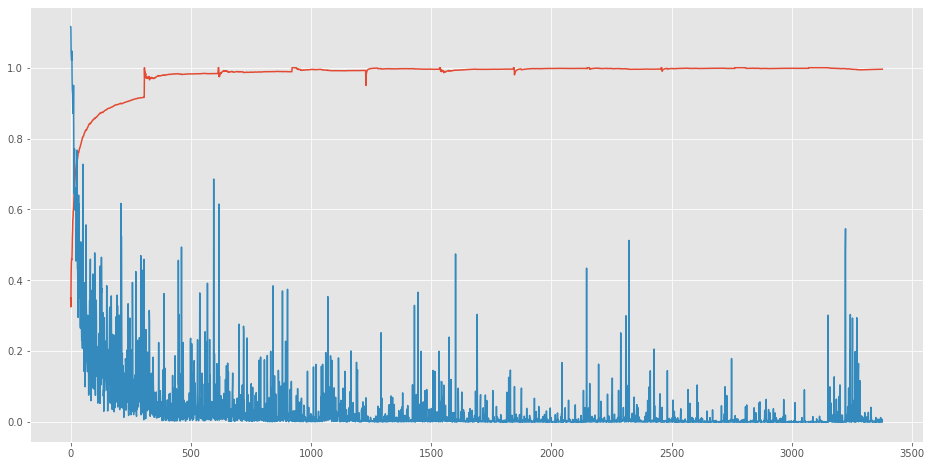

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
plt.plot(history_accuracy)
plt.plot(hist_loss)

In [ ]:
# plt.savefig("LossAndAccuracy",dpi=2048, format = png)

## Model Evaluation

In [ ]:
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
# Evaluate the model on test data

correct = 0
total = 0
predictions=[]
actuals=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred_arr = predicted.cpu().detach().numpy()
        actual_arr = labels.cpu().detach().numpy()
        predictions.append(pred_arr)
        actuals.append(actual_arr)

print('Accuracy of the network on the test images: %f %%'% (100 * correct / total))

Accuracy of the network on the test images: 99.282453 %


In [ ]:
pred=np.concatenate(predictions)
act=np.concatenate(actuals)

In [ ]:
pred_arr = predicted.cpu().detach().numpy()
actual_arr = labels.cpu().detach().numpy()

In [ ]:
pd.crosstab(pred,act,rownames=['Predicted'], colnames=['Actual'])

Actual,0,1,2
Predicted,,,
0,702,2,0
1,0,576,3
2,1,5,244


In [ ]:
datavar.classes

['Covid', 'Normal', 'Pneumonia']

In [ ]:
datavar.class_to_idx

{'Covid': 0, 'Normal': 1, 'Pneumonia': 2}

## Load pretrained model into file

In [ ]:
file = '/content/EN4-epoch 10 model.pth'

In [ ]:
checkpoint = torch.load(file)

In [ ]:
model2 = en4.from_pretrained('efficientnet-b4', num_classes=3)

Loaded pretrained weights for efficientnet-b4


In [ ]:
optimizer2 = optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
model2.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint["epoch"]
loss = checkpoint['loss']

In [ ]:
file_save = '/content/drive/MyDrive/Import to Colab/Models/E4-10epoch-batch16.pth'
# '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/TrainedModelCheckpoints/E4-10epoch-batch16.pth'

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, file_save)

In [ ]:
# Evaluate the model on test data

correct2 = 0
total2 = 0
predictions2=[]
actuals2=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs.data, 1)
        total2 += labels.size(0)
        correct2 += (predicted == labels).sum().item()
        pred_arr2 = predicted.cpu().detach().numpy()
        actual_arr2 = labels.cpu().detach().numpy()
        predictions2.append(pred_arr2)
        actuals2.append(actual_arr2)

print('Accuracy of the network on the test images: %f %%'% (100 * correct2 / total2))

Accuracy of the network on the test images: 99.282453 %


In [ ]:
pred2=np.concatenate(predictions2)
act2=np.concatenate(actuals2)

In [ ]:
pred_arr2 = predicted.cpu().detach().numpy()
actual_arr2 = labels.cpu().detach().numpy()

In [ ]:
pd.crosstab(pred2,act2,rownames=['Predicted'], colnames=['Actual'])

Actual,0,1,2
Predicted,,,
0,702,2,0
1,0,576,3
2,1,5,244
